# Quick Start for Network Wrangler

This notebook should give you a high-level overview of using Wrangler to do the following:  

1. Import a network to wrangler
2. Query network features 
3. Change attributes 
4. Write out resulting network  
5. Make change to a network based on a project card 

In [17]:
import os
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd

from network_wrangler import RoadwayNetwork
from network_wrangler import ProjectCard
from network_wrangler import TransitNetwork

from ipywidgets import HBox, VBox, Output
from IPython.display import display, HTML

%config IPCompleter.greedy=True
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Importing and viewing a network in the standard format 

1. Locate network folder and files 

In [2]:
STPAUL_DIR = os.path.join(os.getcwd(),'../','example','stpaul')

# Roadway Network files
STPAUL_SHAPE_FILE = os.path.join(STPAUL_DIR,"shape.geojson")
STPAUL_LINK_FILE = os.path.join(STPAUL_DIR,"link.json")
STPAUL_NODE_FILE = os.path.join(STPAUL_DIR,"node.geojson")

2. Read in the network

In [3]:
net = RoadwayNetwork.read(
    link_file= STPAUL_LINK_FILE, 
    node_file=STPAUL_NODE_FILE, 
    shape_file=STPAUL_SHAPE_FILE, 
    fast=True        # fast=True means that the network isn't validated against its schema when it is read in. You will want to try both ways.
)

In [4]:
transit_net = TransitNetwork.read(feed_path=STPAUL_DIR)

3. Look at the first three rows of each network component

In [5]:
net.links_df[:3]

,model_link_id,osm_link_id,shstReferenceId,shstGeometryId,u,v,A,B,access,area,bridge,highway,length,maxspeed,name,oneway,tunnel,width,lanes,distance,HOV_access,transit_priority,traveltime_assert,transit_access,drive_access,walk_access,bike_access,transit_walk_access,locationReferences,ref,geometry
0,224,"18214905,18220565",6a22969708104ae2497244f3d079381d,4a454269d65c6619a2d7e2026295a295,493882040,187879468,3230,52771,,,,residential,80.935,,"Arkwright Street,North Rivoli Street",False,,,1,0.050322,0,0,0.0,0,1,1,1,0,"[{'sequence': 1, 'point': [-93.0837695, 44.963...",NaN,"LINESTRING (-93.08377 44.96334, -93.08324 44.9..."
1,280,18218485,bff76735795c148707c774d7f7a0fa6b,13e68dc0fe4477f10b9655ebbd5f8435,493882338,493882339,3261,3262,,,,tertiary,112.639,,East Cayuga Street,False,,,2,0.070096,0,0,0.0,0,1,0,0,0,"[{'sequence': 1, 'point': [-93.0855338, 44.966...",NaN,"LINESTRING (-93.08553 44.96621, -93.08431 44.9..."
2,281,"221685888,221685889,221685893",42b68a489b91dd5a1415fb25fb53de65,9ba14c0a7330177aa938ad0ec43b45f1,493882338,2307229054,3261,131209,,,yes,tertiary,135.753,,East Cayuga Street,True,,,2,0.084513,0,0,0.0,0,1,0,0,0,"[{'sequence': 1, 'point': [-93.0855338, 44.966...",NaN,"LINESTRING (-93.08553 44.96621, -93.08712 44.9..."


In [6]:
net.nodes_df[:3]

,id,travelModelId,isTranNode,isDriveNode,isWalkNode,isBikeNode,outboundReferenceId,inboundReferenceId,geometry,x,y
osmNodeId,,,,,,,,,,,
1924,,1924,0,1,1,1,[],[],POINT (-93.13665429246822 44.96983089628447),-93.136654,44.969831
1925,,1925,0,1,1,1,[],[],POINT (-93.13713235855231 44.96467765580667),-93.137132,44.964678
1930,,1930,0,1,1,1,[],[],POINT (-93.14154395797398 44.95372694803862),-93.141544,44.953727


In [6]:
net.shapes_df[:3]

,id,shstFromIntersectionId,shstToIntersectionId,forwardReferenceId,geometry
0,4a454269d65c6619a2d7e2026295a295,4d0231aa0ebb779f142c2518703ee481,3654951b676940911fe5021b93c90cc5,6a22969708104ae2497244f3d079381d,"LINESTRING (-93.08377 44.96334, -93.08376 44.9..."
1,13e68dc0fe4477f10b9655ebbd5f8435,b6ee5e5a4adca2f379b20fe7ee7ca77d,51013ccb2e52ee1ea83de6d36e4ef268,bff76735795c148707c774d7f7a0fa6b,"LINESTRING (-93.08553 44.96621, -93.08524 44.9..."
2,9ba14c0a7330177aa938ad0ec43b45f1,b6ee5e5a4adca2f379b20fe7ee7ca77d,863278524c056439c207888e8f09d04e,42b68a489b91dd5a1415fb25fb53de65,"LINESTRING (-93.08553 44.96621, -93.08574 44.9..."


In [7]:
transit_net.feed.routes[:3]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,3-111,0,3,U of M - Como Av - Energy Park Dr - Maryland Av,NaN,3,http://www.metrotransit.org/route/3,NaN,0
1,16-111,2,16,University Av - Midway,NaN,3,http://www.metrotransit.org/route/16,NaN,0
2,21-111,0,21,Uptown - Lake St - Midway - Selby Av,NaN,3,http://www.metrotransit.org/route/21,NaN,0


In [8]:
transit_net.feed.stop_times[:3]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_distance,timepoint,stop_is_skipped
0,14940701-JUN19-MVS-BUS-Weekday-01,0.0,0.0,56107,1,0,0,NaN,NaN,NaN
1,14940701-JUN19-MVS-BUS-Weekday-01,0.0,0.0,42823,2,0,0,NaN,NaN,NaN
2,14940701-JUN19-MVS-BUS-Weekday-01,0.0,0.0,44061,3,0,0,NaN,NaN,NaN


In [9]:
transit_net.feed.frequencies[0:3]

,trip_id,headway_secs,start_time,end_time
0,14940701-JUN19-MVS-BUS-Weekday-01,3600,21600.0,32400.0
1,14940963-JUN19-MVS-BUS-Weekday-01,1200,21600.0,32400.0
2,14940964-JUN19-MVS-BUS-Weekday-01,1200,32400.0,54000.0


In [10]:
transit_net.feed.trips[0:3]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,trip_destination,trip_short_name,trip_route_name,pub_dir_id,rm_block_id
0,452-111,JUN19-MVS-BUS-Weekday-01,14940701-JUN19-MVS-BUS-Weekday-01,Westbound 452 Express / Minneapolis,1,1874,4520004,1.0,NaN,NaN,NaN,NaN,NaN
1,63-111,JUN19-MVS-BUS-Weekday-01,14940963-JUN19-MVS-BUS-Weekday-01,Eastbound 63K E 3rd St / Lower Afton / Via Sunray,0,1562,630009,1.0,NaN,NaN,NaN,NaN,NaN
2,63-111,JUN19-MVS-BUS-Weekday-01,14940964-JUN19-MVS-BUS-Weekday-01,Westbound 63B Grand Ave/Westgate Sta,1,1556,630010,1.0,NaN,NaN,NaN,NaN,NaN


In [11]:
transit_net.feed.stops[:3]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,wheelchair_boarding,model_node_id,osm_link_id,node_ssid,parent_station
0,10037,NaN,Fillmore Ave E & Robert St,Far side E,44.941361,-93.084769,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,1.0,57992,187891416,98e48a4ff360a8833c1f04b975fb8f73,NaN
1,10039,NaN,Fillmore Ave E & State St,Near side E,44.943261,-93.080287,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,2.0,46975,187868185,1203d85e0764f1e36a8a598977364db0,NaN
2,10040,NaN,Fillmore Ave E & Lafayette Rd W,Near side E,44.943613,-93.078382,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,2.0,57958,187891352,3127e296d73928bc1cec808a7acd6d3a,NaN


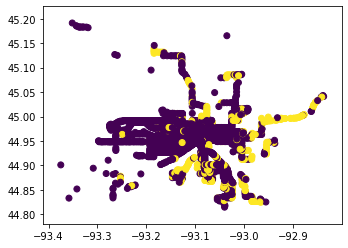

In [21]:
stops_gdf = gpd.GeoDataFrame(
    transit_net.feed.stops, geometry=gpd.points_from_xy(transit_net.feed.stops.stop_lon, transit_net.feed.stops.stop_lat))
stops_gdf.plot(column='wheelchair_boarding')

In [24]:
transit_net.feed.shapes[:5]
# this can be a geodataframe, but have it turned off for now b/c of issues with partridge

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_osm_link_id,shape_model_node_id
0,4520004,44.865526,-93.132239,1,1977347010,81615
1,4520004,44.865422,-93.131905,2,1977346948,81582
2,4520004,44.865402,-93.131606,3,1977346942,81579
3,4520004,44.865735,-93.130994,4,186841006,57097
4,4520004,44.865827,-93.130689,5,186759898,24534


## 2. Query Network Features

Most of Network wrangler operates by querying a portion of the network and then making changes to it.  

Queries take the form of Python Dictionaries or can be read-in as YAML which is then converted to a python dictionary.

If a query has already been made, it is stored in the network so that it will not take up computing power to find it again.

### Highway Segment Selection

Highway selections have three required components: 'link', 'A', and 'B'.  

'link' must either have a specified name, or an 'osmid'

'A' and 'B' must specify some sort of unique identifier which is found in the data structure (AKA, it should return a single node).

If not all the links connecting A to B have the 'name' or an 'osmid', wrangler will connect the dots from A-->B using as many streets with the correct name/osmid as possible.

In [27]:
easy_highway_selection = \
{
    'link':[
        {'name': ['6th', 'Sixth', 'sixth']}, #find streets that have one of the various forms of 6th
        ],
     'A':{'osm_node_id': '187899923'}, # start searching for segments at A
     'B':{'osm_node_id': '187865924'}, # end at B
}

In [28]:
# querying with the selection will return the links that are selected
net.select_roadway_features(easy_highway_selection)

[1125, 4498, 5570]

In [36]:
# wrangler has other information about the facility selection stored under a unique key, including a graph and a route
A_id, B_id = net.orig_dest_nodes_foreign_key(easy_highway_selection)
easy_key = (ProjectCard.build_link_selection_query(easy_highway_selection, unique_model_link_identifiers = ['model_link_id']), A_id, B_id)

G               = net.selections[easy_key]['graph']
selection_route = net.selections[easy_key]['route']
selected_links  = net.selections[easy_key]['selected_links']

#### Visualizing the selection to verify it is correct

In [31]:
try:
    import osmnx as ox
except:
    !conda install osmnx
try:
    import folium
except:
    !conda install folium

## todo make this part of wrangler
## todo visualize with shapes rather than links
    
def folium_node(node, node_name, color='white', icon = ''):
        node_marker = folium.Marker(location=[node['y'],node['x']], 
                                    icon=folium.Icon(icon = icon, color=color), 
                                    tooltip=node_name,
                                   )
        return node_marker
    
def map_selection(stored_selection, A_name, B_name):
        '''
        Shows which links are selected
        '''
        
        
        m = ox.plot_graph_folium(stored_selection['graph'], 
                                 edge_color='blue',
                                 edge_width=5, 
                                 edge_opacity = 0.6,
                                 tiles='cartodbdark_matter')
        
        A     = stored_selection['graph'].nodes[A_name]
        B     = stored_selection['graph'].nodes[B_name]
        
        folium_node(A, A_name, color="green", icon = 'play').add_to(m)
        folium_node(B, B_name, color="pink", icon = 'star').add_to(m)
        
        for _, row in stored_selection['selected_links'].iterrows():
            pl = ox.plot.make_folium_polyline(edge=row, edge_color="green", edge_width=7,
                                      edge_opacity=0.8)
            pl.add_to(m)
            
        
        return m

In [32]:
map_selection(net.selections[easy_key], A_id, B_id)

# this map shows the links that were considered because of their OSMid or their name in blue, 
# and the final selection in green

### More complex selections

You can also select facilities based on their properties.  This selection is tiered from the name/osmid selection.

In [34]:
multi_criteria_selection = \
{
    'link':[
        {'name': ['6th', 'Sixth', 'sixth']}, #find streets that have one of the various forms of 6th
        {'lanes': [1,2]}, # only select links that are either 1 or 2 lanes
         ],
     'A':{'osm_node_id': '187899923'}, # start searching for segments at A
     'B':{'osm_node_id': '187865924'}, # end at B
}
net.select_roadway_features(multi_criteria_selection )

[1125, 4498, 5570]

In [40]:
A_id, B_id = net.orig_dest_nodes_foreign_key(multi_criteria_selection)
multi_criteria_key = (ProjectCard.build_link_selection_query(multi_criteria_selection,unique_model_link_identifiers= ['model_link_id']), A_id, B_id)
map_selection(net.selections[multi_criteria_key], A_id, B_id)

### Transit Selection


Transit trip selection can currently happen by querying trips, routes, etc.

In [41]:
simple_transit_selection = {"route_id": "365-111"}
selected_trips = transit_net.select_transit_features(simple_transit_selection)

transit_net.feed.trips[transit_net.feed.trips.trip_id.isin(selected_trips)]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,trip_destination,trip_short_name,trip_route_name,pub_dir_id,rm_block_id
59,365-111,JUN19-MVS-BUS-Weekday-01,14947182-JUN19-MVS-BUS-Weekday-01,Northbound 365 Express / Minneapolis,0,1844,3650001,1.0,NaN,NaN,NaN,NaN,NaN


In [44]:
simple_transit_selection = {"route_short_name": "3"}
selected_trips = transit_net.select_transit_features(simple_transit_selection)

transit_net.feed.routes[transit_net.feed.trips.trip_id.isin(selected_trips)]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
5,61-111,0,61,E Hennepin Av - Larpenteur Av - Arcade St,NaN,3,http://www.metrotransit.org/route/61,NaN,0
6,62-111,0,62,Shoreview - Little Canada - Rice St Signal Hills,NaN,3,http://www.metrotransit.org/route/62,NaN,0
7,63-111,0,63,Raymond Sta - Grand Av - Sunray - McKnight Rd,NaN,3,http://www.metrotransit.org/route/63,NaN,0
8,64-111,0,64,Payne - Maryland - White Bear Av - Maplewood Mall,NaN,3,http://www.metrotransit.org/route/64,NaN,0


#### Visualize selection on map

Note that this is a mouthful of code.  I have a todo to write a wrapper around this so that you can easily visualize with an api of something like:  `transit_net.select_transit_features(simple_transit_selection).plot()`

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

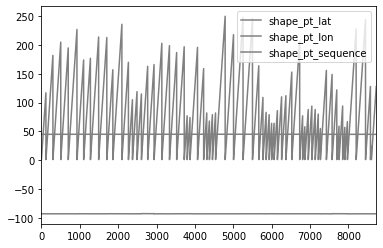

In [43]:
#NOTE not currently working because of partridge/geopandas issues. Working to resolve.
all_routes = transit_net.feed.shapes.plot(color='gray')
transit_net.feed.shapes[transit_net.feed.trips.trip_id.isin(selected_trips)].plot(ax=all_routes, color="red")

## 3. Change Feature Attributes

### Highway Feature Change

In [47]:
selected_highway = {
    "link": [{"name": ["I 35E"]}],
    "A": {"osm_node_id": "961117623"},  
    "B": {"osm_node_id": "2564047368"}
}
selected_links   = net.select_roadway_features(selected_highway)

A_id, B_id = net.orig_dest_nodes_foreign_key(selected_highway)
selected_highway_key = (ProjectCard.build_link_selection_query(selected_highway,unique_model_link_identifiers=['model_link_id']), A_id, B_id)
map_selection(net.selections[selected_highway_key ], A_id, B_id)

In [49]:
net.links_df.loc[selected_links]['lanes']

7539    3
8104    3
Name: lanes, dtype: int64

In [50]:
change = {
    'properties': [
      {
          'property': 'lanes',
          'set': 2,
      }
    ]
}

In [52]:
net.apply_roadway_feature_change(selected_links,change['properties'])
net.links_df.loc[selected_links]['lanes']

7539    2
8104    2
Name: lanes, dtype: int64

#### You can also increment from the existing value using the field `change`
And optionally, you can call out what you think the existing value should be so that it fails if it isn't the case.

In [53]:
change = {
    'properties': [
      {
          'property': 'lanes',
          'existing': 2,
          'change': 1,
      }
    ]
}

net.apply_roadway_feature_change(selected_links,change['properties'])
net.links_df.loc[selected_links]['lanes']

7539    3
8104    3
Name: lanes, dtype: int64

### Transit Feature Change


In [55]:
transit_selection = {"route_short_name": "3"}
change = {
    'properties': [
      {
          'property': 'headway_secs',
          'set': 600, # ten minute headways
      }
    ]
}
# show existing headways
transit_net.feed.frequencies[
    transit_net.feed.trips.trip_id.isin(
        transit_net.select_transit_features(transit_selection)
    )
]

,trip_id,headway_secs,start_time,end_time
5,14941148-JUN19-MVS-BUS-Weekday-01,830,21600.0,32400.0
6,14941151-JUN19-MVS-BUS-Weekday-01,540,21600.0,32400.0
7,14941153-JUN19-MVS-BUS-Weekday-01,696,32400.0,54000.0
8,14941163-JUN19-MVS-BUS-Weekday-01,830,32400.0,54000.0


In [56]:
transit_net.apply_transit_feature_change(
            transit_net.select_transit_features(transit_selection), change['properties']
        )

# show revised headways
transit_net.feed.frequencies[
    transit_net.feed.trips.trip_id.isin(
        transit_net.select_transit_features(simple_transit_selection)
    )
]

,trip_id,headway_secs,start_time,end_time
5,14941148-JUN19-MVS-BUS-Weekday-01,600,21600.0,32400.0
6,14941151-JUN19-MVS-BUS-Weekday-01,600,21600.0,32400.0
7,14941153-JUN19-MVS-BUS-Weekday-01,600,32400.0,54000.0
8,14941163-JUN19-MVS-BUS-Weekday-01,600,32400.0,54000.0


## 4 - Write out Networks

In [55]:
OUTPATH = "/Users/Elizabeth/Downloads"

In [56]:
net.write(filename="my_net", path=OUTPATH)

In [ ]:
transit_net.write(outpath = OUTPATH)

## 5 - Do the whole process with project cards

#### Roadway

In [57]:
roadway_project_card_file = os.path.join(
        STPAUL_DIR, "project_cards", '3_multiple_roadway_attribute_change.yml'
    )
    
roadway_project_card = ProjectCard.read(roadway_project_card_file)

net.apply_roadway_feature_change(
    net.select_roadway_features(roadway_project_card.facility),
    roadway_project_card.properties
)


#### Transit

In [58]:
transit_project_card_file = os.path.join(
    STPAUL_DIR, "project_cards", '8_simple_transit_attribute_change.yml'
)

transit_project_card = ProjectCard.read(transit_project_card_file)
transit_net.apply_transit_feature_change(
    transit_net.select_transit_features(transit_project_card.facility), 
    transit_project_card.properties
)

# Scenarios

Can create a scenario from a base scenario which specifies any base networks if applicable.
You can add projects and apply them all.
You have access to the projects that have been applied.

In [59]:
from network_wrangler import Scenario
scen = Scenario.create_scenario(
    base_scenario={"road_net":net, "transit_net":transit_net}, 
    project_cards_list= [roadway_project_card]
    )

scen.apply_all_projects()

In [60]:
scen.applied_projects

['6th Street Transitway']